In [1]:
import geopandas as gpd
import pandas as pd
import os

In [2]:
prediction_df = pd.read_parquet('Churu_building_footprint_classification.parquet') #Last dataset with predicted type of building
settlements_gdf = gpd.read_file('Churu_neuralNetwork_50_infromal_detection.geojson')

In [3]:
settlements_gdf.head(4) #check that geometry is using 4326

,confidence,class,fill,stroke,geometry
0,1.805664e-35,formal,#1591EA,#1591EA,"POLYGON ((75.36096 28.62944, 75.36096 28.62989..."
1,1.805664e-35,formal,#1591EA,#1591EA,"POLYGON ((75.36096 28.62989, 75.36096 28.63034..."
2,1.805664e-35,formal,#1591EA,#1591EA,"POLYGON ((75.36141 28.62944, 75.36141 28.62989..."
3,1.805664e-35,formal,#1591EA,#1591EA,"POLYGON ((75.36141 28.62989, 75.36141 28.63034..."


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

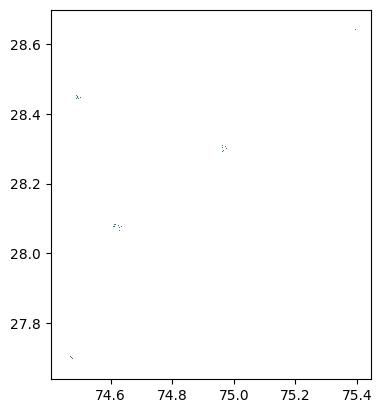

In [4]:
settlements_gdf[settlements_gdf['class']=='informal'].plot()
settlements_gdf.crs

In [5]:
prediction_gdf = gpd.GeoDataFrame(
    prediction_df,
    geometry=gpd.GeoSeries.from_wkb(prediction_df['geometry'])
)
prediction_gdf.crs = "EPSG:3857" 
prediction_gdf_new = prediction_gdf.to_crs(4326)

In [6]:
prediction_gdf_new.head(5) #check that geometry is 4326

,perimeter_in_meters,building_faces,bf_source,confidence,geometry,longitude,latitude,id,area_in_meters,height_mean,...,distance_to_2,nearest_road_type_3,distance_to_3,nearest_road_type_4,distance_to_4,road_density_for_4_fixed,road_density_for_5_fixed,SQN,faces,prediction
0,7.243843,4,google,0.7724,"POLYGON ((74.23236 27.72641, 74.23236 27.72641...",74.232350,27.726409,74.23234975129046:27.72640873664523,0.000125,0.000000,...,1.000000,tertiary,0.024701,unclassified,0.014643,0.040648,0.067323,0.873945,4,Residential
1,9.011801,4,google,0.7108,"POLYGON ((74.84492 28.873, 74.84492 28.87303, ...",74.844915,28.873013,74.84491545220574:28.873013019801967,0.000126,1.000000,...,0.086930,tertiary,0.221931,residential,0.011467,0.148409,0.206338,0.703755,4,Residential
2,6.354292,4,google,0.7123,"POLYGON ((74.22657 27.63066, 74.22656 27.63067...",74.226555,27.630664,74.22655544425939:27.630663527650903,0.000126,1.722222,...,1.000000,tertiary,1.000000,track,0.588414,0.000000,0.000000,0.998249,4,Residential
3,6.957619,4,google,0.7604,"POLYGON ((75.01403 28.33486, 75.01403 28.33487...",75.014020,28.334861,75.0140202674914:28.334861398658834,0.000126,0.000000,...,0.516274,tertiary,0.524725,unclassified,0.077349,0.051521,0.000000,0.914346,4,Residential
4,8.217702,4,google,0.7845,"POLYGON ((74.5701 27.78267, 74.5701 27.7827, 7...",74.570094,27.782683,74.57009354210085:27.782682537523247,0.000127,2.500000,...,1.000000,tertiary,0.026344,unclassified,0.059044,0.070790,0.000000,0.774335,4,Residential


In [7]:
columns_to_add = ['confidence', 'class', 'geometry']
settlements_subset = settlements_gdf[columns_to_add]

In [8]:
merged_gdf = gpd.sjoin(prediction_gdf_new, settlements_subset, how="left", predicate="intersects")

In [9]:
merged_gdf = merged_gdf.drop(columns=['index_right'])

In [10]:
merged_gdf.rename(columns={
    'confidence_right': 'confidence_settlement_clasification',
    'class': 'settlement_clasification'
}, inplace=True)

<Axes: >

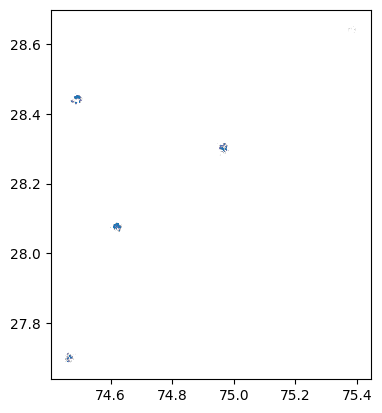

In [11]:
merged_gdf[merged_gdf['settlement_clasification']=='informal'].plot()

In [12]:
len(merged_gdf)

1552488

In [13]:
gdf_no_duplicates = merged_gdf.drop_duplicates(subset='geometry', keep='first')

In [14]:
len(gdf_no_duplicates)

1481134

In [15]:
gdf_no_duplicates.to_parquet('Churu_building_footprint_classification.parquet')